<a href="https://colab.research.google.com/github/erivaschaves/Client/blob/master/Trabalho_Pr%C3%A1tico_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imports necessários
import pandas as pd 
from sklearn import preprocessing
from sklearn import metrics
from scipy.spatial import distance_matrix
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import plotly.graph_objects as go

Carregando a base de dados criminais por Estado

In [2]:
dataset_br = pd.read_excel("/content/indicadoressegurancapublicaufjul20.xlsx")
dataset_br.head()

,UF,Tipo Crime,Ano,Mês,Ocorrências
0,Acre,Estupro,2015,janeiro,6
1,Acre,Furto de veículo,2015,janeiro,0
2,Acre,Homicídio doloso,2015,janeiro,13
3,Acre,Lesão corporal seguida de morte,2015,janeiro,0
4,Acre,Roubo a instituição financeira,2015,janeiro,0


In [3]:
#Verificando os tipos de dados de cada atributo para pre processamento
dataset_br.dtypes 

UF             object
Tipo Crime     object
Ano             int64
Mês            object
Ocorrências     int64
dtype: object

Fazendo uma pequena contagem dos tipos e numeros de crimes

In [5]:
dataset_br['Tipo Crime'].value_counts()

Estupro                                1806
Roubo seguido de morte (latrocínio)    1806
Roubo de veículo                       1805
Homicídio doloso                       1805
Tentativa de homicídio                 1804
Furto de veículo                       1802
Lesão corporal seguida de morte        1784
Roubo a instituição financeira         1763
Roubo de carga                         1747
Name: Tipo Crime, dtype: int64

Fazendo uma pequena contagem dos crimes por ano

In [6]:
dataset_br['Ano'].value_counts()

2018    2910
2017    2893
2019    2889
2016    2884
2015    2879
2020    1667
Name: Ano, dtype: int64

Fazendo uma contagem da quantidade de crimes por estado

In [7]:
dataset_br['UF'].value_counts()

Mato Grosso do Sul     603
Mato Grosso            603
Pernambuco             603
Distrito Federal       603
Rio de Janeiro         603
Pará                   603
Ceará                  603
Roraima                603
Amazonas               603
Espírito Santo         603
Maranhão               603
Piauí                  603
Bahia                  603
Santa Catarina         603
Rio Grande do Sul      602
Minas Gerais           602
Goiás                  602
Sergipe                602
Paraíba                601
Tocantins              599
Acre                   598
Rondônia               598
Alagoas                593
Rio Grande do Norte    586
São Paulo              583
Paraná                 567
Amapá                  547
Name: UF, dtype: int64

Pré processamento da base para preparar para os algoritmos de clusterização.

In [11]:
#Agrupando os tipos de crime deixando como indices o UF e o Ano
dataset_br_group = dataset_br.groupby(["UF","Ano","Tipo Crime"]).sum()
dataset_br_group

Ocorrências
UF        Ano  Tipo Crime                                      
Acre      2015 Estupro                                       42
               Furto de veículo                               0
               Homicídio doloso                             189
               Lesão corporal seguida de morte                3
               Roubo a instituição financeira                 0
...                                                         ...
Tocantins 2020 Roubo a instituição financeira                 0
               Roubo de carga                                 2
               Roubo de veículo                             240
               Roubo seguido de morte (latrocínio)            7
               Tentativa de homicídio                       243

[1452 rows x 1 columns]

In [12]:
dataset_br_group.reset_index(inplace=True)
dataset_br_group.set_index(['UF','Ano'], inplace=True)
dataset_br_group = dataset_br_group.pivot(columns='Tipo Crime')
dataset_br_group.columns = dataset_br_group.columns.to_flat_index()
dataset_br_group.columns = [column if type(column) == str else column[1] for column in dataset_br_group.columns]
dataset_br_group.reset_index(inplace=True)
dataset_br_group

,UF,Ano,Estupro,Furto de veículo,Homicídio doloso,Lesão corporal seguida de morte,Roubo a instituição financeira,Roubo de carga,Roubo de veículo,Roubo seguido de morte (latrocínio),Tentativa de homicídio
0,Acre,2015,42.0,0.0,189.0,3.0,0.0,0.0,0.0,10.0,16.0
1,Acre,2016,36.0,0.0,425.0,1.0,0.0,0.0,0.0,15.0,10.0
2,Acre,2017,108.0,539.0,221.0,0.0,5.0,3.0,849.0,10.0,61.0
3,Acre,2018,260.0,704.0,396.0,0.0,3.0,1.0,1080.0,20.0,86.0
4,Acre,2019,330.0,572.0,292.0,2.0,4.0,4.0,1246.0,14.0,134.0
...,...,...,...,...,...,...,...,...,...,...,...
157,Tocantins,2016,450.0,1499.0,417.0,5.0,27.0,23.0,930.0,14.0,341.0
158,Tocantins,2017,564.0,1539.0,337.0,7.0,23.0,8.0,815.0,11.0,335.0
159,Tocantins,2018,727.0,2092.0,363.0,7.0,7.0,0.0,1091.0,16.0,417.0
160,Tocantins,2019,718.0,1569.0,301.0,7.0,3.0,1.0,701.0,18.0,518.0


Criando e Analisando a matriz de correlação, verificamos uma forte correlação entre o roubo de veiculos e roubo de carga.

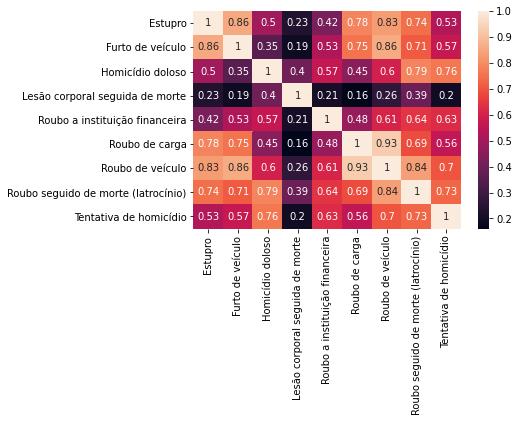

In [13]:
dataset_br_corr = dataset_br_group[['Estupro','Furto de veículo','Homicídio doloso','Lesão corporal seguida de morte','Roubo a instituição financeira','Roubo de carga','Roubo de veículo','Roubo seguido de morte (latrocínio)','Tentativa de homicídio']].corr()
sns.heatmap(dataset_br_corr, xticklabels=['Estupro','Furto de veículo','Homicídio doloso','Lesão corporal seguida de morte','Roubo a instituição financeira','Roubo de carga','Roubo de veículo','Roubo seguido de morte (latrocínio)','Tentativa de homicídio'], yticklabels=['Estupro','Furto de veículo','Homicídio doloso','Lesão corporal seguida de morte','Roubo a instituição financeira','Roubo de carga','Roubo de veículo','Roubo seguido de morte (latrocínio)','Tentativa de homicídio'], annot=True)

Antes de aplicar os algoritmos de clusterização, vamos verificar se existe alguma similaridade entre os casos nos estados

In [14]:
x = dataset_br_group[['Estupro','Furto de veículo','Homicídio doloso','Lesão corporal seguida de morte','Roubo a instituição financeira','Roubo de carga','Roubo de veículo','Roubo seguido de morte (latrocínio)','Tentativa de homicídio']].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dataset_br_norm = pd.DataFrame(x_scaled, index=dataset_br_group.index, columns=['Estupro','Furto de veículo','Homicídio doloso','Lesão corporal seguida de morte','Roubo a instituição financeira','Roubo de carga','Roubo de veículo','Roubo seguido de morte (latrocínio)','Tentativa de homicídio'])
dataset_br_norm.head()

,Estupro,Furto de veículo,Homicídio doloso,Lesão corporal seguida de morte,Roubo a instituição financeira,Roubo de carga,Roubo de veículo,Roubo seguido de morte (latrocínio),Tentativa de homicídio
0,0.000504,0.000000,0.016896,0.009967,0.000000,0.000000,0.000000,0.022857,0.001163
1,0.000000,0.000000,0.055988,0.003322,0.000000,0.000000,0.000000,0.037143,0.000000
2,0.006044,0.004859,0.022196,0.000000,0.031447,0.000283,0.010793,0.022857,0.009884
3,0.018803,0.006346,0.051184,0.000000,0.018868,0.000094,0.013730,0.051429,0.014729
4,0.024679,0.005156,0.033957,0.006645,0.025157,0.000377,0.015841,0.034286,0.024031


In [15]:
#Trocando valores nulos por 0
dataset_br_norm = dataset_br_norm.fillna(0)

In [16]:
from scipy.spatial.distance import pdist, squareform

In [17]:
dataframe_dist = pd.DataFrame(
    squareform(pdist(dataset_br_norm[['Estupro','Furto de veículo','Homicídio doloso','Lesão corporal seguida de morte','Roubo a instituição financeira','Roubo de carga','Roubo de veículo','Roubo seguido de morte (latrocínio)','Tentativa de homicídio']], metric='euclidean')),
    columns = dataset_br_group.UF,
    index = dataset_br_group.UF
)

Verificando a distancia dos dados encontrados entre um estado e outro

In [18]:
long_form = dataframe_dist.unstack()

long_form.index.rename(["Estado A", "Estado B"], inplace=True)
long_form = long_form.to_frame('distancia').reset_index()

In [19]:
long_form[
    (long_form['distancia'] < 0.1) 
    & (long_form['Estado A'] != long_form['Estado B'])
]

,Estado A,Estado B,distancia
11,Acre,Alagoas,0.081685
12,Acre,Amapá,0.069184
16,Acre,Amapá,0.099989
17,Acre,Amapá,0.038081
41,Acre,Distrito Federal,0.088869
...,...,...,...
26216,Tocantins,Roraima,0.024304
26217,Tocantins,Roraima,0.051643
26218,Tocantins,Roraima,0.047229
26219,Tocantins,Roraima,0.052036


Aplicando os algoritmos de clusterização baseado nas metricas de distancias dos dados entre os estados

In [20]:
from sklearn import metrics

for k in range(2, 10):

  kmeans = KMeans(n_clusters=k)
  kmeans.fit(dataset_br_norm[['Estupro','Furto de veículo','Homicídio doloso','Lesão corporal seguida de morte','Roubo a instituição financeira','Roubo de carga','Roubo de veículo','Roubo seguido de morte (latrocínio)','Tentativa de homicídio']])
  score_mean = metrics.silhouette_score(dataset_br_norm[['Estupro','Furto de veículo','Homicídio doloso','Lesão corporal seguida de morte','Roubo a instituição financeira','Roubo de carga','Roubo de veículo','Roubo seguido de morte (latrocínio)','Tentativa de homicídio']], kmeans.labels_, metric='euclidean')
  print(k, score_mean)

2 0.5435279605749905
3 0.5006373434233852
4 0.509624711082641
5 0.35435004071431175
6 0.3616370744002682
7 0.3952021849176228
8 0.4165112914496429
9 0.41094731998115236


Aplicando K-Means

In [21]:
kmeans = KMeans(n_clusters=10,random_state=42)
kmeans.fit(dataset_br_norm[['Estupro','Furto de veículo','Homicídio doloso','Lesão corporal seguida de morte','Roubo a instituição financeira','Roubo de carga','Roubo de veículo','Roubo seguido de morte (latrocínio)','Tentativa de homicídio']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [22]:
clusters = kmeans.labels_.tolist()
clusters_dict = { 'UF': list(dataset_br_group.UF), 'Ano': dataset_br_group.index, 'Cluster': clusters}
dataframe_clusters = pd.DataFrame(clusters_dict, columns = ['UF','Ano','Cluster'])

In [23]:
dataframe_clusters

,UF,Ano,Cluster
0,Acre,0,2
1,Acre,1,2
2,Acre,2,2
3,Acre,3,2
4,Acre,4,2
...,...,...,...
157,Tocantins,157,2
158,Tocantins,158,2
159,Tocantins,159,2
160,Tocantins,160,2


Aplicando Cluster Hierarquico

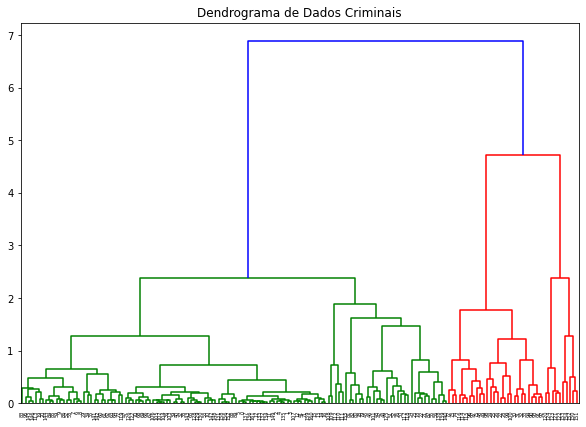

In [24]:
plt.figure(figsize=(10, 7))
plt.title("Dendrograma de Dados Criminais")
dend = shc.dendrogram(shc.linkage(dataset_br_norm, method='ward'))

In [25]:
agg_cluster = AgglomerativeClustering(affinity='euclidean', linkage='ward')
agg_cluster.fit(dataset_br_norm[['Estupro','Furto de veículo','Homicídio doloso','Lesão corporal seguida de morte','Roubo a instituição financeira','Roubo de carga','Roubo de veículo','Roubo seguido de morte (latrocínio)','Tentativa de homicídio']])

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2)

In [26]:
clusters_h = agg_cluster.labels_.tolist()
clusters_dict_h = { 'UF': list(dataset_br_group.UF), 'Ano': dataset_br_group.index, 'Cluster': clusters}
dataframe_clusters_h = pd.DataFrame(clusters_dict_h, columns = ['UF', 'Ano','Cluster'])

In [ ]:
dataframe_clusters_h

,UF,Ano,Cluster
0,Acre,0,2
1,Acre,1,2
2,Acre,2,2
3,Acre,3,2
4,Acre,4,2
...,...,...,...
157,Tocantins,157,2
158,Tocantins,158,2
159,Tocantins,159,2
160,Tocantins,160,2


In [ ]:
metrics.silhouette_score(dataset_br_norm, agg_cluster.labels_, metric='euclidean')

0.5321852583270221

In [ ]:
metrics.silhouette_score(dataset_br_norm, kmeans.labels_, metric='euclidean')

0.4316660954519816

In [28]:
!pip install geopandas

     |████████████████████████████████| 972kB 8.2MB/s 
     |████████████████████████████████| 6.5MB 17.3MB/s 
     |████████████████████████████████| 14.8MB 326kB/s 


In [29]:
import geopandas as gpd

INFOS_UFS = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/bcim_2016_21_11_2018.gpkg", layer = 'lim_unidade_federacao_a')

INFOS_UFS.columns

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:422: RuntimeWarning:

Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.



Index(['nome', 'nomeabrev', 'geometriaaproximada', 'sigla', 'geocodigo',
       'id_produtor', 'id_elementoprodutor', 'cd_insumo_orgao',
       'nr_insumo_mes', 'nr_insumo_ano', 'tx_insumo_documento', 'geometry'],
      dtype='object')

Estado: Sergipe


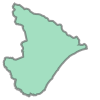

In [30]:
print("Estado: " + INFOS_UFS.nome[4])
INFOS_UFS.geometry[4]

In [ ]:
dataframe_clusters['Cluster'].astype(float)

0      2.0
1      2.0
2      2.0
3      2.0
4      2.0
      ... 
157    2.0
158    2.0
159    2.0
160    2.0
161    2.0
Name: Cluster, Length: 162, dtype: float64

In [31]:
INFOS_UFS.rename({'sigla': 'UF'}, axis = 1, inplace = True)

brasil = INFOS_UFS.merge(dataframe_clusters, on = 'UF', how = 'left')

brasil[['UF','Cluster','geometry']].head()


,UF,Cluster,geometry
0,GO,NaN,"MULTIPOLYGON (((-50.15876 -12.41581, -50.15743..."
1,MS,NaN,"MULTIPOLYGON (((-56.09815 -17.17220, -56.09159..."
2,PR,NaN,"MULTIPOLYGON (((-52.08090 -22.52893, -52.04903..."
3,MG,NaN,"MULTIPOLYGON (((-44.21152 -14.22955, -44.20750..."
4,SE,NaN,"MULTIPOLYGON (((-38.00366 -9.51544, -38.00052 ..."


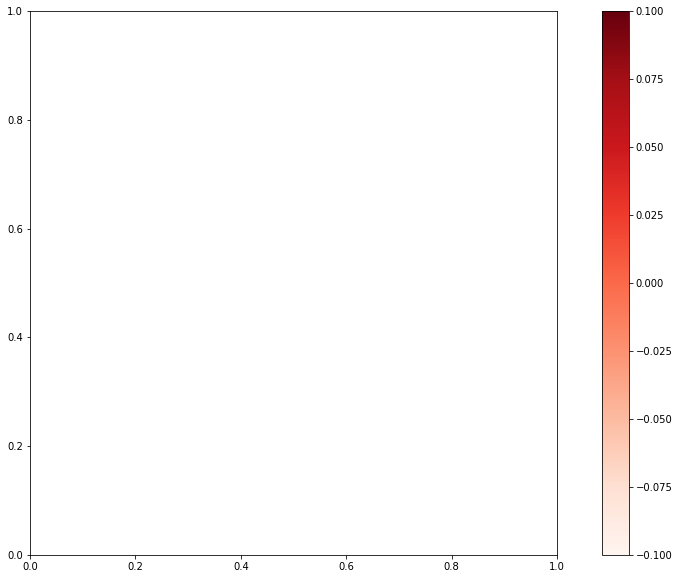

In [32]:
%matplotlib inline

brasil.plot(column  = 'Cluster',

            cmap = 'Reds',
            figsize = (16,10),
            legend = True,
            edgecolor = 'black')

Pequena base de dados do covid-19, com casos confirmados por estado, para efeitos de comparação atualizado até 09/ 12/ 2020 extraidos para criação dessa base: https://www.google.com.br/search?source=hp&ei=9T7RX6zpKefH5OUPztqO6A0&q=covid--19+casos+confirmados&oq=covid--19+casos+confirmados&gs_lcp=CgZwc3ktYWIQAzIICAAQFhAKEB46CAgAELEDEIMBOgsIABCxAxDHARCjAjoOCAAQsQMQgwEQxwEQowI6CAguELEDEIMBOgIIADoFCC4QsQM6AgguOgUILhCTAjoFCAAQsQM6BAgAEB46BAgAEBM6BggAEB4QEzoICAAQFhAeEBM6BggAEBYQHjoICCEQFhAdEB5QlQlYsmZgk2xoAXAAeAGAAeQEiAHTRpIBCzItMTAuMTMuMy4xmAEAoAEBqgEHZ3dzLXdperABAA&sclient=psy-ab&ved=0ahUKEwjst8G36cHtAhXnI7kGHU6tA90Q4dUDCAY&uact=5 

In [33]:
corona_cases = pd.read_excel("/content/Covid.xlsx")
corona_cases.head()

,UF,confirmed_cases
0,SP,1296801
1,MG,444800
2,BA,428034
3,SC,406003
4,RJ,374753


In [34]:
import geopandas as gpd

INFOS_UFS2 = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/bcim_2016_21_11_2018.gpkg", layer = 'lim_unidade_federacao_a')

INFOS_UFS2.columns

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:422: RuntimeWarning:

Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.



Index(['nome', 'nomeabrev', 'geometriaaproximada', 'sigla', 'geocodigo',
       'id_produtor', 'id_elementoprodutor', 'cd_insumo_orgao',
       'nr_insumo_mes', 'nr_insumo_ano', 'tx_insumo_documento', 'geometry'],
      dtype='object')

In [35]:
INFOS_UFS.rename({'sigla': 'UF'}, axis = 1, inplace = True)

brasil = INFOS_UFS.merge(corona_cases, on = 'UF', how = 'left')

brasil[['UF','confirmed_cases','geometry']].head()

,UF,confirmed_cases,geometry
0,GO,287858,"MULTIPOLYGON (((-50.15876 -12.41581, -50.15743..."
1,MS,107235,"MULTIPOLYGON (((-56.09815 -17.17220, -56.09159..."
2,PR,308811,"MULTIPOLYGON (((-52.08090 -22.52893, -52.04903..."
3,MG,444800,"MULTIPOLYGON (((-44.21152 -14.22955, -44.20750..."
4,SE,95493,"MULTIPOLYGON (((-38.00366 -9.51544, -38.00052 ..."


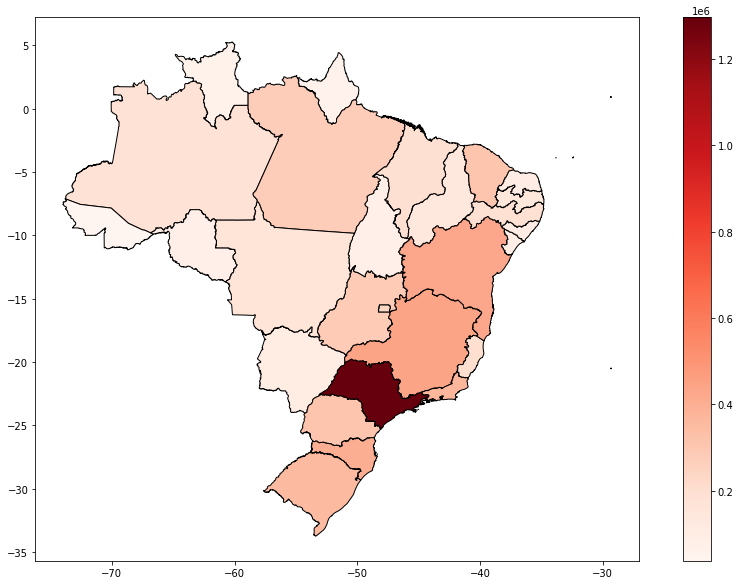

In [36]:
%matplotlib inline

brasil.plot(column  = 'confirmed_cases',

            cmap = 'Reds',
            figsize = (16,10),
            legend = True,
            edgecolor = 'black')